# MXNet WCT Universal Style Transfer

kenstler@

This notebook contains an implementation of [Universal Style Transfer via Feature Transformations](https://arxiv.org/abs/1705.08086), adapted from the TF implementation [here](https://github.com/eridgd/WCT-TF)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import mxnet as mx
import mxnet.ndarray as F
import cv2
from PIL import Image
import numpy as np
import time
import glob

import warnings
warnings.filterwarnings("error")

import multiprocessing as mp
import threading

import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")
import os, sys

from __future__ import division

/home/ubuntu/src/anaconda2/envs/mxnet1/lib/python2.7/site-packages/urllib3/contrib/pyopenssl.py:46: DeprecationWarning: OpenSSL.rand is deprecated - you should use os.urandom instead
  import OpenSSL.SSL


In [2]:
ctx = mx.gpu(0)

## Models

Use VGG19

Convolutional block constructor.

Note: Naming conventions throughout are chosen specifically to match that of the vgg19bn symbol.

In [5]:
def Conv2DBlock(x, num_filter, kernel, activation, number, batch_norm=False, reflect=False):
    if reflect:
            x = mx.sym.pad(x, mode='reflect', pad_width=(0,0,0,0,1,1,1,1), name='rpad_%i' % number)
            x = mx.sym.Convolution(x, kernel=kernel, num_filter=num_filter, pad=(0, 0), name='ConvNdBackward%i' % number, )
    else:
        x = mx.sym.Convolution(x, kernel=kernel, num_filter=num_filter, pad=(1, 1), name='ConvNdBackward%i' % number, )
    number += 1
    if batch_norm:
        gamma = mx.sym.Variable(name='BatchNormBackward%i_bn_gamma' % number)
        beta = mx.sym.Variable(name='BatchNormBackward%i_bn_beta' % number)
        moving_mean = mx.sym.Variable(name='BatchNormBackward%i_bn_moving_mean' % number)
        moving_var = mx.sym.Variable(name='BatchNormBackward%i_bn_moving_var' % number)
        x = mx.sym.BatchNorm(x, name='BatchNormBackward%i_bn' % number, gamma=gamma, beta=beta,\
                             moving_mean=moving_mean, moving_var=moving_var, eps=0.0001, fix_gamma=False,
                            use_global_stats = True)
        number += 1
    if activation:
        return mx.sym.Activation(x, activation, name='ThresholdBackward%i' % number)
    else:
        return x

Encoder. Vgg19 model is not mxnet default, this is a pytorch model w/ batchnorm and normalization.

In [6]:
def build_encoder(ctx, batch_size):
    data = mx.sym.Variable('data')
    
    relu1_1 = Conv2DBlock(data, num_filter=64, kernel=(3,3), activation='relu', number=1, batch_norm=True)
    x = Conv2DBlock(relu1_1, num_filter=64, kernel=(3,3), activation='relu', number=4, batch_norm=True)
    x = mx.sym.Pooling(x, pad=(0, 0), kernel=(2,2), stride=(2,2), pool_type='max', name='MaxPool2dBackward7')
    
    relu2_1 = Conv2DBlock(x, num_filter=128, kernel=(3,3), activation='relu', number=8, batch_norm=True)
    x = Conv2DBlock(relu2_1, num_filter=128, kernel=(3,3), activation='relu', number=11, batch_norm=True)
    x = mx.sym.Pooling(x, pad=(0, 0), kernel=(2,2), stride=(2,2), pool_type='max', name='MaxPool2dBackward14')
    
    relu3_1 = Conv2DBlock(x, num_filter=256, kernel=(3,3), activation='relu', number=15, batch_norm=True)
    x = Conv2DBlock(relu3_1, num_filter=256, kernel=(3,3), activation='relu', number=18, batch_norm=True)
    x = Conv2DBlock(x, num_filter=256, kernel=(3,3), activation='relu', number=21, batch_norm=True)
    x = Conv2DBlock(x, num_filter=256, kernel=(3,3), activation='relu', number=24, batch_norm=True)
    x = mx.sym.Pooling(x, pad=(0, 0), kernel=(2,2), stride=(2,2), pool_type='max', name='MaxPool2dBackward27')
    
    relu4_1 = Conv2DBlock(x, num_filter=512, kernel=(3,3), activation='relu', number=28, batch_norm=True)
    x = Conv2DBlock(relu4_1, num_filter=512, kernel=(3,3), activation='relu', number=31, batch_norm=True)
    x = Conv2DBlock(x, num_filter=512, kernel=(3,3), activation='relu', number=34, batch_norm=True)
    x = Conv2DBlock(x, num_filter=512, kernel=(3,3), activation='relu', number=37, batch_norm=True)
    x = mx.sym.Pooling(x, pad=(0, 0), kernel=(2,2), stride=(2,2), pool_type='max', name='MaxPool2dBackward40')
    
    relu5_1 = Conv2DBlock(x, num_filter=512, kernel=(3,3), activation='relu', number=41, batch_norm=True)
    
    conv_layers = [relu1_1, relu2_1, relu3_1, relu4_1, relu5_1]
    conv_outputs = mx.sym.Group(conv_layers)
    sym, arg_params, aux_params = mx.model.load_checkpoint('vgg19_bn', 0)

    encoder = mx.mod.Module(conv_outputs, fixed_param_names=conv_outputs.list_arguments(), context=ctx, label_names=None)
    encoder.bind([['data', (batch_size, 3, 256, 256)]])
    encoder.set_params(arg_params, aux_params, allow_extra=True, allow_missing=True)
    return encoder

Mappings for decoder constructor.

In [7]:
decoder_blocks = {
    1 : [64],
    2 : [64, 'upsample'],
    3 : [128, 'upsample', 128],
    4 : [256, 'upsample', 256, 256, 256],
    5 : [512, 'upsample', 512, 512, 512]
}

encoder_blocks = {
    1 : [64],
    2 : [64, 'pool', 128],
    3 : [128, 'pool', 256],
    4 : [256, 256, 256, 'pool', 512],
    5 : [512, 512, 512, 'pool', 512]
}

block_output_shapes = {
    1 : (64, 256, 256),
    2 : (128, 128, 128),
    3 : (256, 64, 64),
    4 : (512, 32, 32),
    5 : (512, 16, 16)
}

output_names = {
    1 : 'ThresholdBackward3_output',
    2 : 'ThresholdBackward10_output',
    3 : 'ThresholdBackward17_output',
    4 : 'ThresholdBackward30_output',
    5 : 'ThresholdBackward43_output'
}

This model is where the training happens.

In [8]:
def build_decoder_encoder(ctx, batch_size, block, feature_weight=1, pixel_weight=1, tv_weight=0, res = 256):
    features = mx.sym.Variable('features')
    original = mx.sym.Variable('original')
    x = features
    i = 100
    nblocks = block
    # decoder
    while nblocks:
        for layer in decoder_blocks[nblocks]:
            if isinstance(layer, int):
                x = Conv2DBlock(x, num_filter=layer, kernel=(3,3), activation='relu', number=i, reflect=True)
                i+=3
            elif layer == 'upsample':
                x = mx.sym.UpSampling(x, scale=2, sample_type='nearest', name='upsample%i' % i)
                i+=1
        nblocks -= 1
    generated = Conv2DBlock(x, num_filter=3, kernel=(3,3), activation=None, number=i, reflect=True)
    
    x = generated
    i = 1
    # encoder
    while nblocks < block:
        nblocks +=1
        for layer in encoder_blocks[nblocks]:
            if isinstance(layer, int):
                x = Conv2DBlock(x, num_filter=layer, kernel=(3,3), activation='relu', number=i, batch_norm=True)
                i+=3
            elif layer == 'pool':
                x = mx.sym.Pooling(x, pad=(0, 0), kernel=(2,2), stride=(2,2), pool_type='max', name='MaxPool2dBackward%i' % i)
                i+=1
                
    generated_features = x
    
    feature_loss = feature_weight * mx.sym.mean(mx.sym.square((generated_features - features)))
    
    pixel_loss = pixel_weight * mx.sym.mean(mx.sym.square((generated - original)))
    
    def total_variation_loss(x):
        b, c, r, h = (batch_size, 3, res, res)
        pixel_dif1 = mx.sym.slice(x, begin=(0,0,1,0), end=(b,c,r,h)) - mx.sym.slice(x, begin=(0,0,0,0), end=(b,c,r-1,h))
        pixel_dif2 = mx.sym.slice(x, begin=(0,0,0,1), end=(b,c,r,h)) - mx.sym.slice(x, begin=(0,0,0,0), end=(b,c,r,h-1))
        tot_var = mx.sym.mean((mx.sym.sum_axis(mx.sym.abs(pixel_dif1), axis=(1,2,3)) +
                          mx.sym.sum_axis(mx.sym.abs(pixel_dif1), axis=(1,2,3))))
        return tot_var
    
    if tv_weight > 0:
        tv_loss = tv_weight * total_variation_loss(generated)
    else:
        tv_loss = 0
        
    total_loss = feature_loss + pixel_loss + tv_loss
    loss = mx.sym.MakeLoss(feature_loss + pixel_loss + tv_loss, name='total_loss')
    
    sym, arg_params, aux_params = mx.model.load_checkpoint('vgg19_bn', 0)
    decoder_encoder = mx.mod.Module(
        loss, context=ctx, data_names=('features',), 
        label_names=('original',),
        fixed_param_names = sym.get_internals()[output_names[block]].list_arguments()[1:]
    )
    decoder_encoder.bind([['features', (batch_size,) + block_output_shapes[block]]],
                         label_shapes=[['original', (batch_size, 3, 256, 256)]])
    decoder_encoder.init_params(mx.initializer.Xavier(magnitude=6))
    decoder_encoder.set_params(arg_params, aux_params, allow_extra=True, allow_missing=True)
    return decoder_encoder

Build encoder.

In [10]:
encoder = build_encoder(ctx, batch_size=batch_size)

Decoders.

In [11]:
decoder_encoder_1 = build_decoder_encoder(ctx, batch_size=batch_size, block=1)
decoder_encoder_2 = build_decoder_encoder(ctx, batch_size=batch_size, block=2)
decoder_encoder_3 = build_decoder_encoder(ctx, batch_size=batch_size, block=3)
decoder_encoder_4 = build_decoder_encoder(ctx, batch_size=batch_size, block=4)
decoder_encoder_5 = build_decoder_encoder(ctx, batch_size=batch_size, block=5)

File list for image iter.

In [9]:
content_files = [[1.0, f] for f in glob.glob('data/content/*.jpg')]

In [9]:
batch_size = 8

Image iterator does random cropping and normalization.

In [13]:
image_iter = mx.image.ImageIter(batch_size, data_shape=(3, 256, 256), imglist=content_files, path_root='.',
                               shuffle=True,
                               resize = 512,
                               rand_crop = True,
                               mean= True,
                               std= True,
                               inter_method=1
                               )

Postprocessing helper func to recover valid image matrix.

In [3]:
mean= 255*np.array([[[0.485, 0.456, 0.406]]])
std= 255*np.array([[[0.229, 0.224, 0.225]]])

In [4]:
def postprocess(img, mu=mean, sigm=std):
    img = np.swapaxes(np.swapaxes(img, 1, 2), 0, 2)
    img = img*sigm
    img += mu
    img = np.clip((img), 0, 255).astype('uint8')
    return img

Initialize each decoder model.

In [14]:
lr_sch1 = mx.lr_scheduler.FactorScheduler(step=1000, factor=1/(1+5e-5))
lr_sch2 = mx.lr_scheduler.FactorScheduler(step=1000, factor=1/(1+5e-5))
lr_sch3 = mx.lr_scheduler.FactorScheduler(step=1000, factor=1/(1+5e-5))
lr_sch4 = mx.lr_scheduler.FactorScheduler(step=1000, factor=1/(1+5e-5))
lr_sch5 = mx.lr_scheduler.FactorScheduler(step=1000, factor=1/(1+5e-5))

decoder_encoder_1.init_optimizer(optimizer = 'adam', 
                               optimizer_params=(
                                   ('learning_rate', 1E-4),
                                   ('lr_scheduler', lr_sch1),
                                   ('rescale_grad', 1.0),
                                   ('beta1', 0.9),
                                   ('beta2', 0.999)
                              ))
decoder_encoder_2.init_optimizer(optimizer = 'adam', 
                               optimizer_params=(
                                   ('learning_rate', 1E-4),
                                   ('lr_scheduler', lr_sch2),
                                   ('rescale_grad', 1.0),
                                   ('beta1', 0.9),
                                   ('beta2', 0.999)
                              ))
decoder_encoder_3.init_optimizer(optimizer = 'adam', 
                               optimizer_params=(
                                   ('learning_rate', 1E-4),
                                   ('lr_scheduler', lr_sch3),
                                   ('rescale_grad', 1.0),
                                   ('beta1', 0.9),
                                   ('beta2', 0.999)
                              ))
decoder_encoder_4.init_optimizer(optimizer = 'adam', 
                               optimizer_params=(
                                   ('learning_rate', 1E-4),
                                   ('lr_scheduler', lr_sch4),
                                   ('rescale_grad', 1.0),
                                   ('beta1', 0.9),
                                   ('beta2', 0.999)
                              ))
decoder_encoder_5.init_optimizer(optimizer = 'adam', 
                               optimizer_params=(
                                   ('learning_rate', 1E-4),
                                   ('lr_scheduler', lr_sch5),
                                   ('rescale_grad', 1.0),
                                   ('beta1', 0.9),
                                   ('beta2', 0.999)
                              ))

In [15]:
encoder.output_shapes

[('ThresholdBackward3_output', (8, 64L, 256L, 256L)),
 ('ThresholdBackward10_output', (8, 128L, 128L, 128L)),
 ('ThresholdBackward17_output', (8, 256L, 64L, 64L)),
 ('ThresholdBackward30_output', (8, 512L, 32L, 32L)),
 ('ThresholdBackward43_output', (8, 512L, 16L, 16L))]

In [16]:
decoder_encoders = [decoder_encoder_1, decoder_encoder_2, decoder_encoder_3, decoder_encoder_4, decoder_encoder_5]

For one forward pass of the encoder, we can do forward backward passes for all five decoder-encoders.

In [17]:
smoothing_constant = .01
curr_losses = [[], [], [], [], []]
moving_losses = [[], [], [], [], []]
total_iters = 16000

In [ ]:
i = 0
while True:
    if i == total_iters:
        break
    try:
        encoder_batch = next(image_iter)
    except StopIteration:
        image_iter.reset()
        continue
    original = encoder_batch.data
    encoder.forward(encoder_batch)
    features = encoder.get_outputs()
    for j, feature in enumerate(features):
        decoder_encoder_batch = mx.io.DataBatch(data = [feature], label=original)
        decoder_encoders[j].forward_backward(decoder_encoder_batch)
        loss = decoder_encoders[j].get_outputs()[0]
        decoder_encoders[j].update()
        curr_loss = F.mean(loss).asscalar()
        curr_losses[j].append(curr_loss)
        moving_loss = (curr_losses[j][-1] if i == 0
                           else (1 - smoothing_constant) * moving_losses[j][-1] + (smoothing_constant) * curr_losses[j][-1])
        moving_losses[j].append(moving_loss)
    if i % 200 == 0:
        print "Moving Losses for Decoders: 1 %0.5f 2 %0.5f 3 %0.5f 4 %0.5f 5 %0.5f" % (moving_losses[0][-1],
                                                                                       moving_losses[1][-1],
                                                                                       moving_losses[2][-1],
                                                                                       moving_losses[3][-1],
                                                                                       moving_losses[4][-1])
    i += 1
end = time.time() - start

Moving Losses for Decoders: 1 1.41330 2 1.44243 3 1.48376 4 1.32374 5 1.29719
Moving Losses for Decoders: 1 0.57778 2 0.44463 3 0.39383 4 0.48327 5 0.81277
Moving Losses for Decoders: 1 0.15567 2 0.13938 3 0.15535 4 0.26770 5 0.61838
Moving Losses for Decoders: 1 0.05906 2 0.07781 3 0.10335 4 0.20833 5 0.53200
Moving Losses for Decoders: 1 0.03138 2 0.06094 3 0.08898 4 0.19093 5 0.47917
Moving Losses for Decoders: 1 0.02066 2 0.04999 3 0.07762 4 0.17171 5 0.44569
Moving Losses for Decoders: 1 0.01585 2 0.04433 3 0.07153 4 0.16337 5 0.43133
Moving Losses for Decoders: 1 0.01342 2 0.04060 3 0.06787 4 0.15754 5 0.42659
Moving Losses for Decoders: 1 0.01123 2 0.03641 3 0.06243 4 0.14849 5 0.41114
Moving Losses for Decoders: 1 0.01026 2 0.03473 3 0.06219 4 0.14646 5 0.40240
Moving Losses for Decoders: 1 0.00963 2 0.03300 3 0.05810 4 0.14558 5 0.39388
Moving Losses for Decoders: 1 0.00844 2 0.03010 3 0.05621 4 0.14006 5 0.38016
Moving Losses for Decoders: 1 0.00791 2 0.02919 3 0.05503 4 0.13

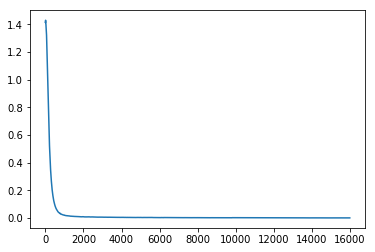

In [20]:
plt.plot(moving_losses[0])

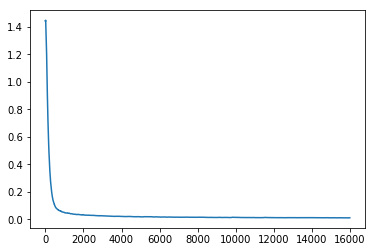

In [21]:
plt.plot(moving_losses[1])

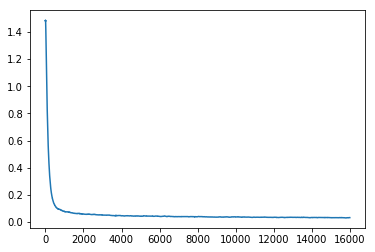

In [22]:
plt.plot(moving_losses[2])

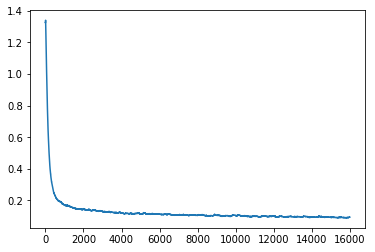

In [23]:
plt.plot(moving_losses[3])

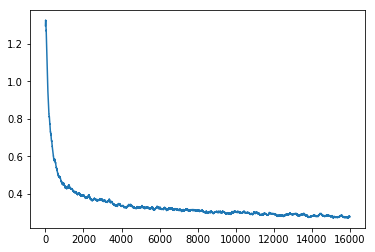

In [24]:
plt.plot(moving_losses[4])

In [26]:
for i, decoder_encoder in enumerate(decoder_encoders):
    decoder_encoder.save_checkpoint('decoder_%i' % (i+1), 16000)

## Test

When loading the models we just trained, we only need the model up to the decoder output. This list corresponds to the final decoder layer for each respective decoder.

In [10]:
decoder_output_layers = ['ConvNdBackward103_output',
                         'ConvNdBackward107_output',
                         'ConvNdBackward114_output',
                         'ConvNdBackward127_output',
                         'ConvNdBackward140_output']

Load decoders. All five decoders and an encoder can fit on one GPU (p3)

In [11]:
decoders = []
for i in range(5):
    tsym, targ_params, taux_params = mx.model.load_checkpoint('decoder_%i' % (i+1), 16000)
    decode_sym = tsym.get_internals()[decoder_output_layers[i]]
    decoder = mx.mod.Module(decode_sym, data_names=('features',), label_names=None, context=mx.gpu(2))
    decoder.bind(data_shapes=[['features', (1,) + block_output_shapes[i+1]]], for_training=False)
    decoder.set_params(targ_params, taux_params, allow_missing=True, allow_extra=True)
    decoders.append(decoder)

In [12]:
test_encoder = build_encoder(mx.gpu(2), 1)

Build test iterators at 512x512.

In [46]:
test_content_iter = mx.image.ImageIter(1, data_shape=(3, 512, 512), imglist=content_files, path_root='.',
                               shuffle=True,
                               resize = 512,
                               rand_crop = True,
                               mean= True,
                               std= True,
                               inter_method=1
                               )

In [14]:
style_files = [[1.0, f] for f in glob.glob('data/style/*.jpg')]

In [47]:
test_style_iter = mx.image.ImageIter(1, data_shape=(3, 512, 512), imglist=style_files, path_root='.',
                               shuffle=True,
                               resize = 512,
                               rand_crop = True,
                               mean= True,
                               std= True,
                               inter_method=1
                               )

This is adapted for MXNet from the wct function at https://github.com/eridgd/WCT-TF/blob/master/utils.py .

This function does WTC on feature maps, which involves calculating eigenvectors / values for both sets of features.

In [39]:
def wct_mxnet(content, style, alpha=0.6, eps=1e-5):
    '''Whiten-Color Transform, p.4 of the Universal Style Transfer: https://arxiv.org/pdf/1705.08086.pdf
    '''    

    content_flat = content.reshape((-1, content.shape[1]*content.shape[2]))
    style_flat = style.reshape((-1, style.shape[1]*style.shape[2]))

    mc = content_flat.mean(axis=1, keepdims=True)
    fc = content_flat - mc

    fcfc = F.dot(fc, fc.T) / (content.shape[1]*content.shape[2] - 1)

    Ec, wc = F.linalg.syevd(fcfc)
    sorted_indices_c = F.argsort(wc, is_ascend=False)
    wc = wc[sorted_indices_c]
    Ec = Ec[sorted_indices_c]
    Ec = Ec.T

    Dc_sq_inv = F.array(np.linalg.inv(np.sqrt(np.abs(np.diag(wc.asnumpy()+eps))))).as_in_context(wc.context)

    fc_hat = F.dot(F.dot(F.dot(Ec,Dc_sq_inv),Ec.T),fc)

    ms = style_flat.mean(axis=1, keepdims=True)
    fs = style_flat - ms

    fsfs = F.dot(fs, fs.T) / (style.shape[1]*style.shape[2] - 1)

    Es, ws = F.linalg.syevd(fsfs)
    sorted_indices_s = F.argsort(ws, is_ascend=False)
    ws = ws[sorted_indices_s]
    Es = Es[sorted_indices_s]
    Es = Es.T

    Ds_sq = F.sqrt(F.array(np.abs(np.diag(ws.asnumpy()+eps))).as_in_context(ws.context))

    fcs_hat = F.dot(F.dot(F.dot(Es,Ds_sq),Es.T),fc_hat)

    fcs_hat = fcs_hat + ms

    blended = alpha*fcs_hat + (1 - alpha)*(fc)

    # CxH*W -> CxHxW
    blended = blended.reshape(content.shape)
    
    return F.expand_dims(blended, 0)

Runs coarse-to-fine multi-level stylization. Block let's you choose starting level, the higher the block the more intense the style transfer. Alpha is a mixing parameter for the WCT output w/ it's input.

In [35]:
def style_transfer(content, style, block=5, alpha=0.6):
    test_content_batch = mx.io.DataBatch(data = content)
    test_style_batch = mx.io.DataBatch(data = style)
    for i in range(block):
        test_encoder.forward(test_content_batch)
        content_features = [cf.copy() for cf in test_encoder.get_outputs()]
        test_encoder.forward(test_style_batch)
        style_features = test_encoder.get_outputs()
        fcs_hat = wct_mxnet(content_features[block-i-1][0], style_features[block-i-1][0], alpha=alpha)
        decoders[block-i-1].forward(mx.io.DataBatch(data = [fcs_hat]))
        decoded = decoders[block-i-1].get_outputs()[0]
        test_content_batch = mx.io.DataBatch(data = [decoded])
    return decoded

In [ ]:
test_content = next(test_content_iter).data
test_style = next(test_style_iter).data

width = 12
height = 12
plt.figure(figsize=(width, height))
plt.subplot(121)
plt.imshow(postprocess(test_content[0][0].asnumpy()))
plt.subplot(122)
plt.imshow(postprocess(test_style[0][0].asnumpy()))

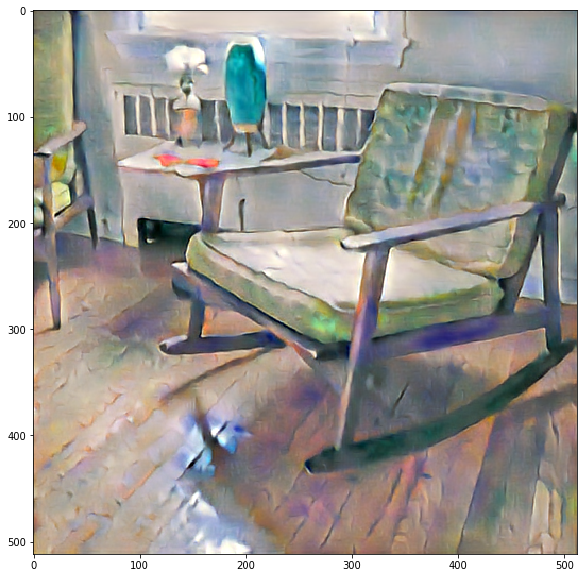

In [135]:
test_content_batch = mx.io.DataBatch(data = test_content)
test_style_batch = mx.io.DataBatch(data = test_style)

decoded = style_transfer(test_content, test_style, block=4)

width = 10
height = 10
plt.figure(figsize=(width, height))
plt.imshow(postprocess(decoded[0].asnumpy()))